<a href="https://colab.research.google.com/github/vhrique/ELF/blob/main/02.a_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages

In [1]:
!pip install pytorch_lightning > packages.txt

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from glob import glob
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset, DataLoader

# Data loading

In [3]:
df = pd.read_parquet('https://drive.google.com/uc?export=download&id=1R7yQshjMkB2nFZ1OMM__EnIoKvihLrZq')
df.head()

,unit,cycle,cond_1,cond_2,cond_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,filename,group,RUL,cycle_max,split
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,392.0,2388.0,100.0,39.06,23.4190,train_FD001.txt,1,191,192,train
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,392.0,2388.0,100.0,39.00,23.4236,train_FD001.txt,1,190,192,train
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,390.0,2388.0,100.0,38.95,23.3442,train_FD001.txt,1,189,192,train
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,392.0,2388.0,100.0,38.88,23.3739,train_FD001.txt,1,188,192,train
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,393.0,2388.0,100.0,38.90,23.4044,train_FD001.txt,1,187,192,train


In [4]:
dev_df = df.query('split == "train"')
test_df = df.query('split == "test"')

In [5]:
train_df = dev_df.query('group == 1 and unit > 10')
val_df = dev_df.query('group == 1 and unit <= 10')
test_df = test_df.query('group == 1')

# Exploratory Data Analysis

In [6]:
# Add any EDA code here

# Data Preprocessing

In [7]:
def normalize_data(df, columns, data_max=None, data_min=None):
    new_df = df.copy()
    if data_max is None:
        data_max = new_df[columns].max()
    if data_min is None:
        data_min = new_df[columns].min()
    new_df.loc[:, columns] = (new_df[columns] - data_min)/(data_max - data_min)
    new_df = new_df.fillna(0)
    return new_df, data_max, data_min

In [8]:
experiment_columns = ['group', 'unit', 'cycle']
condition_columns = [f'cond_{i+1}' for i in range(3)]
sensor_columns = [f'sensor_{i+1}' for i in range(21)]
feature_columns = condition_columns + sensor_columns
column_names = feature_columns + experiment_columns

train_df_norm, data_max, data_min = normalize_data(train_df, feature_columns)
val_df_norm, _, _ = normalize_data(val_df, feature_columns, data_max, data_min)
test_df_norm, _, _ = normalize_data(test_df, feature_columns, data_max, data_min)

# Modelling

## Pytorch Dataloader

In [9]:
class TimeSeriesDataset(Dataset):
    def __init__(self, df, feature_columns, unit_column, group_column, target_column, sequence_length=30, step_size=1):
        self.df = df.copy()
        self.feature_columns = feature_columns
        self.unit_column = unit_column
        self.group_column = group_column
        self.target_column = target_column
        self.sequence_length = sequence_length
        self.step_size = step_size

        # Group by unit and group
        self.grouped_data = self.df.groupby([group_column, unit_column])

        # Store the start indices for each unit's sequences
        self.indices = self._compute_indices()

    def _compute_indices(self):
        """
        Computes start indices for each unit's time series, based on the step size and sequence length.
        """
        indices = []
        for (group, unit), unit_data in self.grouped_data:
            unit_data_length = len(unit_data)
            # Compute the valid start indices for each time series
            num_samples = (unit_data_length - self.sequence_length) // self.step_size + 1
            for i in range(num_samples):
                start_idx = i * self.step_size
                indices.append((group, unit, start_idx))
        return indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        """
        Retrieves the sample at the given index. Dynamically extracts the sequence from the data.
        """
        group, unit, start_idx = self.indices[idx]
        unit_data = self.grouped_data.get_group((group, unit))  # Retrieve the specific time series

        # Extract the features for the sequence
        features = unit_data[self.feature_columns].values[start_idx:start_idx + self.sequence_length].T
        rul = unit_data[self.target_column].values[start_idx + self.sequence_length - 1].astype(int)
        return torch.tensor(features, dtype=torch.float32), torch.tensor(min(150,rul.item()), dtype=torch.float32)

In [10]:
sequence_length = 30

In [11]:
train_dataset = TimeSeriesDataset(train_df_norm, feature_columns, 'unit', 'group', 'RUL', sequence_length)
val_dataset = TimeSeriesDataset(val_df_norm, feature_columns, 'unit', 'group', 'RUL', sequence_length)
test_dataset = TimeSeriesDataset(test_df_norm, feature_columns, 'unit', 'group', 'RUL', sequence_length)

In [16]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

## ANN Model

In [17]:
class MLPModel(pl.LightningModule):
    def __init__(self, input_channels, sequence_length=30, hidden_size=128, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.model = nn.Sequential(
            nn.Linear(input_channels * sequence_length, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x.view(x.size(0), -1))

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y.unsqueeze(-1))
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y.unsqueeze(-1))
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

## Training and Evaluation Loops

In [18]:
model = MLPModel(input_channels=len(feature_columns), sequence_length=sequence_length)

trainer = Trainer(
    max_epochs=10,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=3, mode='min'),
        ModelCheckpoint(monitor='val_loss', mode='min', save_top_k=1)
    ]
)

trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | model     | Sequential | 108 K  | train
1 | criterion | MSELoss    | 0      | train
-------------------------------------------------
108 K     Trainable params
0         Non-trainable params
108 K     Total params
0.436     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

# Evaluation on Full Unit

In [23]:
@torch.no_grad()
def evaluate_full(model, loader):
    model.eval()
    labels = []
    predictions = []
    for i, (inputs, targets) in enumerate(loader):
        # Forward pass
        outputs = model(inputs.to(model.device))
        labels.extend(targets.tolist())
        predictions.extend(outputs.detach().cpu().tolist())
    return labels, predictions

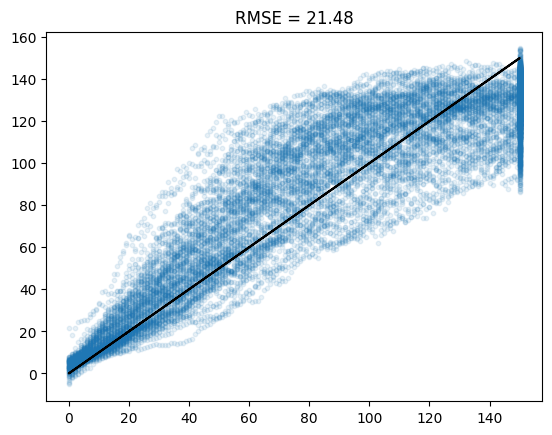

In [24]:
y_train, yh_train = evaluate_full(model, train_loader)

plt.scatter(y_train, yh_train, s=10, alpha=0.1)
plt.plot(y_train, y_train, 'k')
plt.title(f'RMSE = {np.sqrt(mean_squared_error(y_train, yh_train)):.2f}')
plt.show()

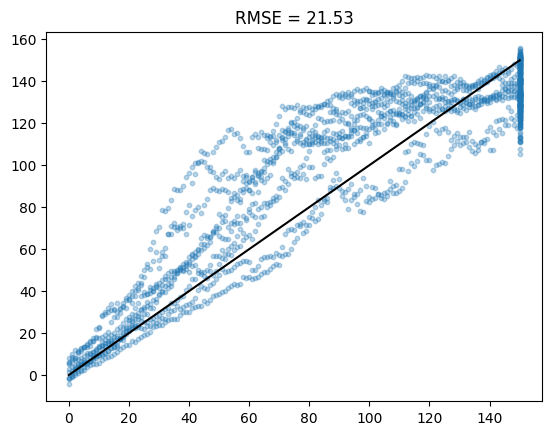

In [25]:
y_val, yh_val = evaluate_full(model, val_loader)

plt.scatter(y_val, yh_val, s=10, alpha=0.3)
plt.plot(y_val, y_val, 'k')
plt.title(f'RMSE = {np.sqrt(mean_squared_error(y_val, yh_val)):.2f}')
plt.show()

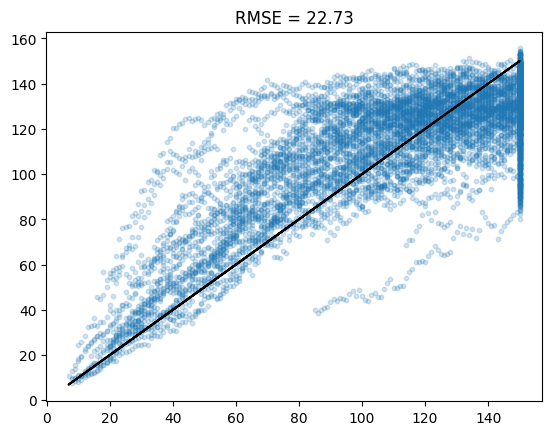

In [26]:
y_test, yh_test = evaluate_full(model, test_loader)

plt.scatter(y_test, yh_test, s=10, alpha=0.2)
plt.plot(y_test, y_test, 'k')
plt.title(f'RMSE = {np.sqrt(mean_squared_error(y_test, yh_test)):.2f}')
plt.show()

# Evaluation on Last Cycle of Each Unit

In [27]:
@torch.no_grad()
def evaluate_last_cycle(model, dataframe, feature_columns):
    model.eval()
    labels = []
    predictions = []
    for unit in dataframe.unit.unique():
        df_unit = dataframe.query(f'unit == {unit}')
        unit_dataset = TimeSeriesDataset(df_unit, feature_columns, 'unit', 'group', 'RUL')
        X, y = unit_dataset[-1]
        y_pred = model(X.unsqueeze(0).to(model.device))
        labels.append(y.item())
        predictions.append(y_pred.detach().cpu().item())
    return labels, predictions

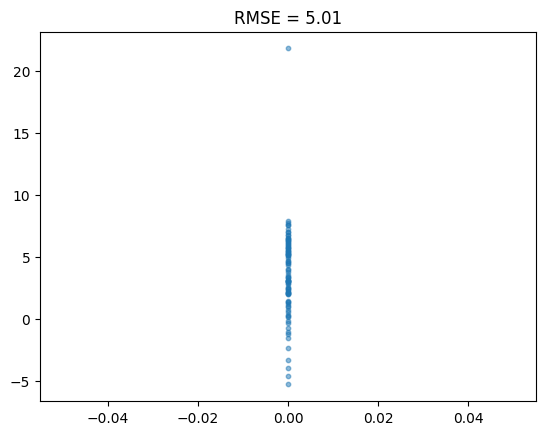

In [28]:
y_train, yh_train = evaluate_last_cycle(model, train_df_norm, feature_columns)

plt.scatter(y_train, yh_train, s=10, alpha=0.5)
plt.plot(y_train, y_train, 'k')
plt.title(f'RMSE = {np.sqrt(mean_squared_error(y_train, yh_train)):.2f}')
plt.show()

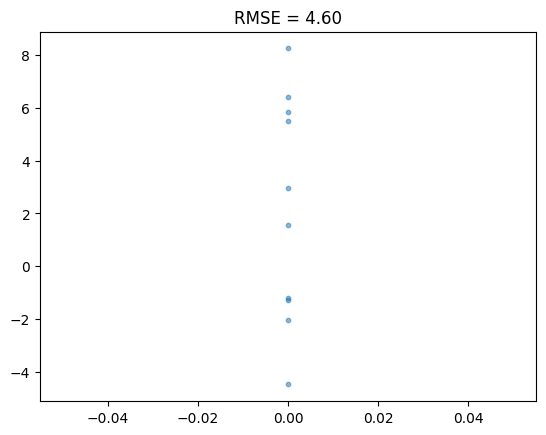

In [29]:
y_val, yh_val = evaluate_last_cycle(model, val_df_norm, feature_columns)

plt.scatter(y_val, yh_val, s=10, alpha=0.5)
plt.plot(y_val, y_val, 'k')
plt.title(f'RMSE = {np.sqrt(mean_squared_error(y_val, yh_val)):.2f}')
plt.show()

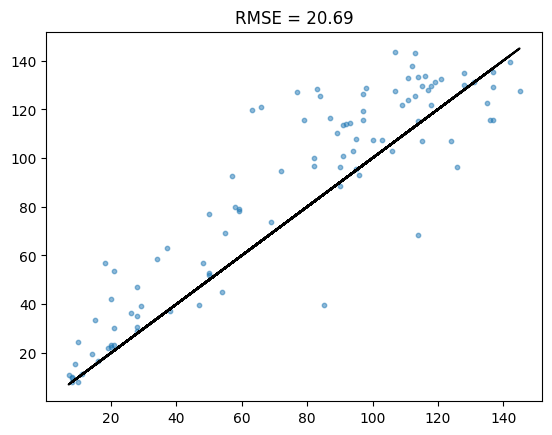

In [30]:
y_test, yh_test = evaluate_last_cycle(model, test_df_norm, feature_columns)

plt.scatter(y_test, yh_test, s=10, alpha=0.5)
plt.plot(y_test, y_test, 'k')
plt.title(f'RMSE = {np.sqrt(mean_squared_error(y_test, yh_test)):.2f}')
plt.show()

In [31]:
from google.colab.runtime import unassign
unassign()